#### Tutorial 3:  Regularization Approaches

In this notebook, we will investigate several regularization techniques namely Elastic Weight Consolidation and Knowledge distilation. If you haven't already observed it, models usually suffer from the problem of catastrophic forgetting when trained on a sequence of tasks. That is, it forgets the past information while learning the new information. EWC and Knowledge Distillation are two such approaches that helps us maintain the stability and plasticity of the model. 

Reference paper:  [EWC](https://arxiv.org/abs/2502.11756) , [Knowledge Distillation](https://amit-s.medium.com/everything-you-need-to-know-about-knowledge-distillation-aka-teacher-student-model-d6ee10fe7276)


In [1]:
#!pip install torchvision==0.18.0 
!pip show torch torchvision
import torch 
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
from torchvision.models import resnet18
import random
import matplotlib.pyplot as plt


Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\github repositorys\llml25-tutorial_notebooks\.venv\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchtext, torchvision
---
Name: torchvision
Version: 0.22.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: c:\github repositorys\llml25-tutorial_notebooks\.venv\lib\site-packages
Requires: numpy, pillow, torch
Required-by: 


#### Loading the dataset

In this notebook, we will be using Mnist and the permuted version of Mnist dataset. 

-- TO-DO --
- First, download the Mnist dataset from torchvision and define the dataset object. 

In [2]:
# Notwendige Imports (einige sind bereits in anderen Zellen vorhanden, daher hier nur make_grid und np)
from torchvision.utils import make_grid
import numpy as np

# Mittelwert und Standardabweichung für eventuelle Normalisierung (hier nicht zwingend benötigt)
mean = torch.tensor([0.4589, 0.4384, 0.4011])
std = torch.tensor([0.2793, 0.2724, 0.2835])

# MNIST Datensätze laden
mnist_trainset = datasets.MNIST(
    root='/app/src/Mnist', train=True, download=True, transform=transforms.ToTensor()
)
mnist_testset = datasets.MNIST(
    root='/app/src/Mnist', train=False, download=True, transform=transforms.ToTensor()
)

# Konfigurationsdictionary für spätere Nutzung
config = {'size': 28, 'channels': 1, 'classes': 10}

# Datensatzgrößen ausgeben
print(f"Trainset size: {len(mnist_trainset)}, Testset size: {len(mnist_testset)}")


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 291kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.22MB/s]

Trainset size: 60000, Testset size: 10000


#### Helper function: Visualization

- Provided the visualization function to plot instances belonging to different class 

In [3]:
#@title Visualization functions
def multi_context_barplot(axis, accs, title=None):
    '''Generate barplot using the values in [accs].'''
    contexts = len(accs)
    axis.bar(range(contexts), accs, color='k')
    axis.set_ylabel('Testing Accuracy (%)')
    axis.set_xticks(range(contexts), [f'Context {i+1}' for i in range(contexts)])
    if title is not None:
        axis.set_title(title)

def plot_examples(axis, dataset, context_id=None):
    '''Plot 25 examples from [dataset].'''
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)
    image_tensor, _ = next(iter(data_loader))
    image_grid = make_grid(image_tensor, nrow=5, pad_value=1) # pad_value=0 would give black borders
    axis.imshow(np.transpose(image_grid.numpy(), (1,2,0)))
    if context_id is not None:
        axis.set_title("Context {}".format(context_id+1))
    axis.axis('off')

#### Permuted Mnist 

1. we need to define a function to permute the pixels of a image. 
2. We will basically use the original Mnist dataset samples and pass the function over each samples to create our Mnist dataset. 

In [5]:
# Function to apply a given permutation the pixels of an image.
def permutate_image_pixels(image, permutation):
    '''Permutate the pixels of [image] according to [permutation].'''
    if permutation is None:
        return image
    # image: torch.Tensor of shape (C, H, W)
    c, h, w = image.shape
    flat = image.view(-1)
    permuted = flat[permutation]
    return permuted.view(c, h, w)
    
# Class to create a dataset with images that have all been transformed in the same way.
class TransformedDataset(torch.utils.data.Dataset):
    '''To modify an existing dataset with a transform.
    Useful for creating different permutations of MNIST without loading the data multiple times.'''

    def __init__(self, original_dataset, transform=None, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        (input, target) = self.dataset[index]
        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return (input, target)

#### Define the sequential tasks

-- TO-DO --
1. We will use only two tasks in this notebook,  denoted as contexts. 
2. We will use the "full" Mnist datasset as our first task and the permuted Mnist dataset as our second task. 

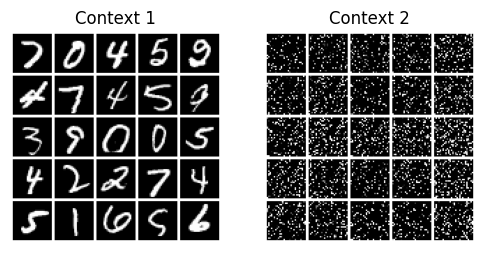

In [6]:
# Wir definieren zwei Kontexte: 
# Kontext 0 = Original MNIST, Kontext 1 = permutiertes MNIST
import numpy as np

contexts = 2  # Anzahl der Aufgaben/Kontexte

# Erzeuge für jeden Kontext eine Permutation (Kontext 0: keine Permutation, Kontext 1: zufällige Permutation)
permutations = [None] + [np.random.permutation(config['size']**2) for _ in range(contexts-1)]

# Listen für Trainings- und Testdatensätze der jeweiligen Kontexte
train_datasets = []
test_datasets = []

# Für jeden Kontext: Erzeuge einen Datensatz mit der jeweiligen Permutation
for context_id, perm in enumerate(permutations):
    # Trainingsdatensatz mit Permutation
    train_datasets.append(
        TransformedDataset(
            mnist_trainset, 
            transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p))
        )
    )
    # Testdatensatz mit Permutation
    test_datasets.append(
        TransformedDataset(
            mnist_testset, 
            transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p))
        )
    )

# Visualisierung: Zeige für jeden Kontext Beispielbilder an
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))
for context_id in range(contexts):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)
plt.show()


#### Model definition

1. Define a simple MLP based network
    - It may only consist of 2-3 linear layers in total with output node of 10; as we have 10 classes in Mnist 
    - As you already know the input shape of Mnist is (1, 28, 28). So, we have to use nn.FLatten() as your first layer if you are using a purely MLP architecture. 
    

In [7]:
#model = models.alexnet(pretrained=False, num_classes=10)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Die Eingabegröße ist 1*28*28 = 784 (MNIST-Bilder)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)  # Erste vollverbundene Schicht
        self.fc2 = nn.Linear(256, 128)    # Zweite vollverbundene Schicht
        self.fc3 = nn.Linear(128, 10)     # Ausgabeschicht (10 Klassen für MNIST)

    def forward(self, x):
        # Bild in Vektor umwandeln
        x = self.flatten(x)
        # Erste Schicht + Aktivierungsfunktion
        x = F.relu(self.fc1(x))
        # Zweite Schicht + Aktivierungsfunktion
        x = F.relu(self.fc2(x))
        # Ausgabeschicht (Logits für 10 Klassen)
        x = self.fc3(x)
        return x

In [12]:
# Print info regarding number of parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)

# Zähle die Gesamtanzahl der Parameter im Modell
total_params = 0
for param in model.parameters():
      total_params += param.numel()  # numel() gibt die Anzahl der Elemente im Tensor zurück

# Ausgabe der Gesamtanzahl der Parameter und gerundet in K (Tausender)
print("--> this network has {} parameters (~{}K)".format(total_params, round(total_params / 1000)))

#model.calculate_fisher_info(train_datasets[0], fisher_labels='exact', fisher_n=100, allowed_classes=None)

--> this network has 235146 parameters (~235K)


#### Initialize the Fischer information matrix 

1. It should be of the shape of the actual model parameters, (model.state_dict()). That means, the information matrix should have placeholders for each layer of the model. 

In [11]:
def initialize_fisher_info(model):
    """
    Initialisiert die Fisher-Informationsmatrix für das gegebene Modell.
    Die Matrix hat für jeden Parameter im Modell einen Tensor gleicher Form, 
    der mit Nullen gefüllt ist. Dies dient als Platzhalter für spätere Berechnungen.
    """
    # Dictionary, das für jeden Parameternamen einen Null-Tensor gleicher Form speichert
    est_fisher_info = {}
    for name, param in model.named_parameters():
        # Erzeuge einen Tensor mit Nullen in der gleichen Form wie der Parameter
        est_fisher_info[name] = torch.zeros_like(param)
    return est_fisher_info

# Testaufruf: Initialisiere die Fisher-Informationsmatrix für das aktuelle Modell
fisher_info = initialize_fisher_info(model)

# Ausgabe zur Kontrolle: Zeige die Namen und Formen der initialisierten Matrizen
for name, tensor in fisher_info.items():
    print(f"{name}: shape={tensor.shape}, dtype={tensor.dtype}")
        


fc1.weight: shape=torch.Size([256, 784]), dtype=torch.float32
fc1.bias: shape=torch.Size([256]), dtype=torch.float32
fc2.weight: shape=torch.Size([128, 256]), dtype=torch.float32
fc2.bias: shape=torch.Size([128]), dtype=torch.float32
fc3.weight: shape=torch.Size([10, 128]), dtype=torch.float32
fc3.bias: shape=torch.Size([10]), dtype=torch.float32


#### Calculate the Fisher matrix 

We have four choices to create our Fischer information matrix 
- Exact: When we iterate over all the samples and calculate the fischer for each individual samples 
- Exact and Sample: We calculate the fischer for N samples 
- True: When we calculate the fischer based on the true class 
- Predicted: When we calculate the fischer based on the predicted class 

Store the values in the previously initialized network. 

In [16]:
def calculate_fisher_info(train_set, fisher_labels='exact', fisher_n=None, allowed_classes=None):
    """
    Berechnet die Fisher-Informationsmatrix für das aktuelle Modell.
    Args:
        train_set: Datensatz, auf dem die Fisher-Information berechnet wird.
        fisher_labels: 'exact', 'true' oder 'pred' (siehe Aufgabenstellung).
        fisher_n: Anzahl der Stichproben (None = alle).
        allowed_classes: falls gesetzt, werden nur diese Klassen berücksichtigt.
    Returns:
        est_fisher_info: Dictionary mit Fisher-Information pro Parameter.
    """
    model.eval()
    # Initialisiere Fisher-Informationsmatrix mit Nullen (wie in initialize_fisher_info)
    est_fisher_info = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False)
    sample_count = 0

    for index, (x, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if fisher_n is not None and sample_count >= fisher_n:
            break
        x, label = x.to(device), label.to(device)

        # Optional: Nur bestimmte Klassen berücksichtigen
        if allowed_classes is not None and label.item() not in allowed_classes:
            continue

        # Vorwärtsdurchlauf
        output = model(x)

        # Auswahl des Labels für die Berechnung der Log-Likelihood
        if fisher_labels == 'exact':
            # Nutze das tatsächliche Label aus dem Datensatz
            target = label
        elif fisher_labels == 'true':
            # Nutze das tatsächliche Label (wie 'exact')
            target = label
        elif fisher_labels == 'pred':
            # Nutze das vom Modell vorhergesagte Label
            target = output.argmax(dim=1)
        else:
            raise ValueError("fisher_labels muss 'exact', 'true' oder 'pred' sein.")

        # Berechne die negative Log-Likelihood für das gewählte Label
        nll = torch.nn.functional.cross_entropy(output, target)
        # Setze Gradienten auf Null
        model.zero_grad()
        # Rückwärtsdurchlauf: Berechne Gradienten der NLL bzgl. der Modellparameter
        nll.backward()

        # Addiere das Quadrat der Gradienten zu est_fisher_info
        for name, param in model.named_parameters():
            if param.grad is not None:
                est_fisher_info[name] += (param.grad.detach() ** 2)

        sample_count += 1

    # Mittelwert über alle betrachteten Stichproben
    for name in est_fisher_info:
        est_fisher_info[name] /= max(1, sample_count)

    return est_fisher_info

# --- Testaufrufe ---

# Beispiel: Berechne Fisher-Information auf den ersten 100 Samples des ersten Kontextes (Original MNIST)
fisher_info_exact = calculate_fisher_info(train_datasets[0], fisher_labels='exact', fisher_n=100)
print("Fisher-Information (exact, 100 Samples):")
for name, tensor in fisher_info_exact.items():
    print(f"{name}: shape={tensor.shape}, mean={tensor.mean().item():.6f}")

# Beispiel: Berechne Fisher-Information auf den ersten 50 Samples des zweiten Kontextes (permutiertes MNIST) mit predicted labels
fisher_info_pred = calculate_fisher_info(train_datasets[1], fisher_labels='pred', fisher_n=50)
print("Fisher-Information (pred, 50 Samples):")
for name, tensor in fisher_info_pred.items():
    print(f"{name}: shape={tensor.shape}, mean={tensor.mean().item():.6f}")


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 100/60000 [00:00<01:15, 789.88it/s]


Fisher-Information (exact, 100 Samples):
fc1.weight: shape=torch.Size([256, 784]), mean=0.000010
fc1.bias: shape=torch.Size([256]), mean=0.000093
fc2.weight: shape=torch.Size([128, 256]), mean=0.000018
fc2.bias: shape=torch.Size([128]), mean=0.001129
fc3.weight: shape=torch.Size([10, 128]), mean=0.000330
fc3.bias: shape=torch.Size([10]), mean=0.089855


  0%|          | 50/60000 [00:00<01:36, 618.65it/s]

Fisher-Information (pred, 50 Samples):
fc1.weight: shape=torch.Size([256, 784]), mean=0.000008
fc1.bias: shape=torch.Size([256]), mean=0.000082
fc2.weight: shape=torch.Size([128, 256]), mean=0.000017
fc2.bias: shape=torch.Size([128]), mean=0.001107
fc3.weight: shape=torch.Size([10, 128]), mean=0.000328
fc3.bias: shape=torch.Size([10]), mean=0.088453


### Define the EWC loss

Implement the function to define the EWC loss. 
the EWC regularization term is given by:
$$
\mathcal{L}^{(k)}_{\text{regularization}_{\text{EWC}}}\left(\boldsymbol{\theta}\right) = \frac{1}{2} \sum_{i=1}^{N_{\text{params}}} \tilde{F}_{ii}^{(k)} \left(\theta_i - \hat{\theta}_{i}^{(k)} \right)^2
$$
whereby $\hat{\theta}_{i}^{(k)}$ is the $i^{\text{th}}$ element of $\hat{\boldsymbol{\theta}}^{\left(k\right)}$, which is the vector with parameter values at the end of training of task $k$, and $\tilde{F}_{ii}^{(k)}$ is an approximation of $F_{ii}^{(k)}$, the $i^{\text{th}}$ diagonal element of $\boldsymbol{F}^{(k)}$, which is the Fisher Information matrix of task $k$ evaluated at $\hat{\boldsymbol{\theta}}^{(k)}$.

In [17]:
def ewc_loss(model, fisher_info, prev_params):
    """
    Berechnet den EWC-Regularisierungsterm für das gegebene Modell.
    Args:
        model: Das aktuelle Modell (nn.Module).
        fisher_info: Dictionary mit Fisher-Information pro Parameter (z.B. fisher_info_exact).
        prev_params: Dictionary mit den gespeicherten Parametern nach Task 1 (state_dict nach erstem Training).
    Returns:
        ewc_reg: Skalarwert des EWC-Regularisierungsterms.
    """
    ewc_reg = 0.0
    # Iteriere über alle Parameter des Modells
    for name, param in model.named_parameters():
        # Nur Parameter berücksichtigen, die auch in fisher_info und prev_params enthalten sind
        if name in fisher_info and name in prev_params:
            # Fisher-Information (Diagonal) für diesen Parameter
            fisher = fisher_info[name]
            # Parameterwert nach Task 1 (als Tensor)
            prev_param = prev_params[name]
            # Quadratische Abweichung berechnen
            param_diff = param - prev_param
            # EWC-Term: 0.5 * Fisher * (theta - theta_old)^2, aufsummiert über alle Elemente
            ewc_reg += (fisher * param_diff.pow(2)).sum()
    # Faktor 0.5 wie in der Formel
    return 0.5 * ewc_reg

# --- Testaufruf ---

# Beispiel: Speichere die aktuellen Parameter nach Task 1
prev_params = {name: param.clone().detach() for name, param in model.named_parameters()}

# Beispiel: Berechne EWC-Loss für das aktuelle Modell mit fisher_info_exact und prev_params
ewc_value = ewc_loss(model, fisher_info_exact, prev_params)
print(f"EWC-Loss (Task 1, fisher_info_exact): {ewc_value.item():.6f}")

# Beispiel: Nach Veränderung eines Parameters sollte der Wert steigen
with torch.no_grad():
    for name, param in model.named_parameters():
        param.add_(0.01)  # Kleine Änderung an allen Parametern

ewc_value_changed = ewc_loss(model, fisher_info_exact, prev_params)
print(f"EWC-Loss nach Parameteränderung: {ewc_value_changed.item():.6f}")

EWC-Loss (Task 1, fisher_info_exact): 0.000000
EWC-Loss nach Parameteränderung: 0.000208


#### Sequential training with EWC

#### Define the training and the validation function

In [18]:
import os

#optimizer = optim.Adam(model.parameters(), lr=0.01)
def train_model(model,  train_loader, optimizer, criterion, task, ewc= False, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if ewc == True:
                loss += 100. * ewc_loss()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
            # Print statistics

        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {running_acc/len(train_loader):.4f}")

        #test_model(model, test_loader[task], criterion)
    if not os.path.exists('/app/src/output'):
        os.makedirs('/app/src/output')
    torch.save(model.state_dict(), f'/app/src/output/model_task_{task}.pth')

def test_model(model, test_loader, criterion, context= 0):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
    #print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy of context {context} is: {running_acc/len(test_loader):.4f}")

##### Train on first context

- Let's the train the model on the first context 


In [49]:
model.to('cuda')
loader = torch.utils.data.DataLoader(train_datasets[0], batch_size=128, shuffle=True)
train_model(model, loader, optimizer, loss, task= 0,ewc= False, num_epochs=2)
#model.calculate_fisher_info(train_dataset[0], fisher_labels='all', fisher_n=None, allowed_classes=None)
    

Epoch [1/2], Accuracy: 0.9309
Epoch [2/2], Accuracy: 0.9643


1. Evaluate the model on both the contexts and report the accuracy. 
- you should see a performance degradation on the second task which is normal as it hasnot been trained on it

In [50]:
contexts = 2
for i in range(contexts):
    test_loader = torch.utils.data.DataLoader(test_datasets[i], batch_size=128, shuffle=False)

    test_model(model, test_loader, loss , context= i)

Test Accuracy of context 0 is: 0.9658
Test Accuracy of context 1 is: 0.0922


##### Train on context 2

- Now train on the context 2 and evaluate the model on both the contexts. You should observe a performance degradation on the context 1. Signalling Catastrophic Forgetting !!!

In [67]:
model.load_state_dict(torch.load('/app/src/output/model_task_0.pth'))
optimizer = optim.Adam(model.parameters(), lr=0.01)
loader = torch.utils.data.DataLoader(train_datasets[1], batch_size=128, shuffle=True)
train_model(model, loader, optimizer, loss, task= 1,ewc= False, num_epochs=2)

/tmp/ipykernel_4655/1301658764.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/app/src/output/model_task_0.pth'))


Epoch [1/2], Accuracy: 0.9220
Epoch [2/2], Accuracy: 0.9625


In [68]:
contexts = 2
for i in range(contexts):
    test_loader = torch.utils.data.DataLoader(test_datasets[i], batch_size=128, shuffle=False)

    test_model(model, test_loader, loss , context= i)

Test Accuracy of context 0 is: 0.6615
Test Accuracy of context 1 is: 0.9636


#### EWC: Sequentially train the model with EWC

- Now Train the model on the first task and save it. 
- Calculate the Fischer matrix using the model from the first context 
- Now train the train the model on the context 2 using EWC loss. 


In [60]:
model_ = Net()
model_.load_state_dict(torch.load('/app/src/output/model_task_0.pth'))
dict_ = torch.load('/app/src/output/model_task_0.pth')

Now Evaluate the model on two contexts

#### Knowledge Distillation

For KD, we need a teacher model which we will use it to infer knowledge from. 
- So first, perform a joint training and save it a teacher model

In [159]:
torch.save(model.state_dict(), '/app/src/output/model_teacher.pth')

##### Define your training loop with KD loss



In [ ]:
def train(model, criterion, train_loader, task, num_epochs=1, kd=False):
    model.train()
    #loader_ = train_loader[0]
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        loader_ = iter(train_loader)
        for i, (inputs, labels) in enumerate(train_loader[task]):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if kd == True:
                with torch.no_grad():
                    
                    """ TODO """

                    
                loss += kd_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {running_acc/len(train_loader):.4f}")

        test_model(model, test_loader[task], criterion)
    #if not os.path.exists('/app/src/output'):
    #    os.makedirs('/app/src/output')
    #torch.save(model.state_dict(), f'/app/src/output/model_task_{task}.pth')

def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            acc = (outputs.argmax(dim=1) == labels).float().mean()
            running_acc += acc.item()
    #print(f"Test Loss: {running_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {running_acc/len(test_loader):.4f}")


### Train and Evaluate your model on two contexts. 